# `chi2_visualize3.ipynb`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import Leadangle_wave as Wave
from Leadangle_fit_JunoUVS import eqwlong_err
from Leadangle_fit_JunoUVS import scaleheight
from Leadangle_fit_JunoUVS import create_argmesh
from Leadangle_fit_JunoUVS import TEB_transit
from UniversalColor import UniversalColor
from SharedX import ShareXaxis
from legend_shadow import legend_shadow

UC = UniversalColor()
UC.set_palette()

F = ShareXaxis()
F.fontsize = 20
F.fontname = 'Liberation Sans Narrow'
F.set_default()

# F.set_figparams()
# F.initialize()

Importing Library
done


In [2]:
exname = '1001/20250428_002'
target_moon = 'Io'
target_fp = ['MAW']
Zi = 1.3
Te = 6     # [eV]

# メモ
# 001/20250423_001: 3d (50, 3, 60) Eu [MAW] (PJ 7)
# 001/20250423_002: 3d (50, 3, 60) Eu [MAW] (PJ 10)
# 001/20250423_003: 3d (50, 3, 60) Eu [MAW] (PJ 3)
# 001/20250423_004: 3d (50, 3, 60) Eu [MAW] (PJ 4)
# 001/20250423_005: 3d (50, 3, 60) Eu [MAW] (PJ 11)
# -
# 002/20250427_001: 3d (50, 3, 60) Eu [MAW] (PJ 7)
# 002/20250427_002: 3d (50, 3, 60) Eu [MAW] (PJ 10)
# 002/20250427_003: 3d (50, 3, 60) Eu [MAW] (PJ 3)
# 002/20250427_004: 3d (50, 3, 60) Eu [MAW] (PJ 4)
# 002/20250427_005: 3d (50, 3, 60) Eu [MAW] (PJ 11)
# 002/20250427_006: 3d (50, 3, 60) Io [MAW] (PJ 3)
# 002/20250427_007: 3d (50, 3, 60) Io [MAW] (PJ 5)
# 002/20250427_008: 3d (50, 3, 60) Io [MAW] (PJ 7)
# 002/20250427_009: 3d (50, 3, 60) Io [MAW] (PJ 8)


chi2_1d = np.loadtxt('results/fit/'+exname+'/params_chi2.txt')
Ai_info = np.loadtxt('results/fit/'+exname+'/params_Ai.txt')
ni_info = np.loadtxt('results/fit/'+exname+'/params_ni.txt')
Ti_info = np.loadtxt('results/fit/'+exname+'/params_Ti.txt')
H_1d = np.loadtxt('results/fit/'+exname+'/params_H.txt')
eqlead_est_MAW = np.loadtxt('results/fit/'+exname+'/eqlead_est_MAW.txt')
eqlead_obs_MAW = np.loadtxt('results/fit/'+exname+'/eqlead_obs_MAW.txt')
eqlead_est_TEB = np.loadtxt('results/fit/'+exname+'/eqlead_est_TEB.txt')
eqlead_obs_TEB = np.loadtxt('results/fit/'+exname+'/eqlead_obs_TEB.txt')
sigma_y_MAW = np.loadtxt('results/fit/'+exname+'/sigma_y_MAW.txt')
sigma_y_TEB = np.loadtxt('results/fit/'+exname+'/sigma_y_TEB.txt')
hem_obs = np.loadtxt('results/fit/'+exname+'/hems_obs.txt')
moon_S3wlon_obs = np.loadtxt('results/fit/'+exname+'/moon_S3wlon_obs.txt')

# パラメータ空間(meshgrid → 1d)の作成
Ai_1d, ni_1d, Ti_1d, _, _, _ = create_argmesh(Ai_info[0], Ai_info[1], int(Ai_info[2]), 'linear',
                                              ni_info[0], ni_info[1], int(
                                                  ni_info[2]), 'log',
                                              Ti_info[0], Ti_info[1], int(Ti_info[2]), 'log')

chi2_3d = chi2_1d.reshape(int(ni_info[2]), int(Ai_info[2]), int(Ti_info[2]))
H_3d = H_1d.reshape(int(ni_info[2]), int(Ai_info[2]), int(Ti_info[2]))
Ai_3d = Ai_1d.reshape(int(ni_info[2]), int(Ai_info[2]), int(Ti_info[2]))
ni_3d = ni_1d.reshape(int(ni_info[2]), int(Ai_info[2]), int(Ti_info[2]))
Ti_3d = Ti_1d.reshape(int(ni_info[2]), int(Ai_info[2]), int(Ti_info[2]))
eqlead_est_MAW_3d = eqlead_est_MAW[1].reshape(
    int(ni_info[2]), int(Ai_info[2]), int(Ti_info[2]))

print('Parameter ranges:')
print('Ai:', np.min(Ai_3d), np.max(Ai_3d))
print('ni:', np.min(ni_3d), np.max(ni_3d))
print('Ti:', np.min(Ti_3d), np.max(Ti_3d))
print('Degree of freedom:', (eqlead_est_MAW.shape[0]-3))

Parameter ranges:
Ai: 20.0 24.0
ni: 499.9999999999999 4999.9999999999945
Ti: 9.999999999999998 999.9999999999999
Degree of freedom: 29


In [3]:
# %% Constants
MU0 = 1.26E-6            # 真空中の透磁率
AMU2KG = 1.66E-27        # 原子質量をkgに変換するファクタ [kg]
RJ = 71492E+3            # JUPITER RADIUS [m]
MJ = 1.90E+27            # JUPITER MASS [kg]
C = 2.99792E+8           # LIGHT SPEED [m/s]
G = 6.67E-11             # 万有引力定数  [m^3 kg^-1 s^-2]

Psyn_io = (12.89)*3600      # Moon's synodic period [sec]
Psyn_eu = (11.22)*3600      # Moon's synodic period [sec]
Psyn_ga = (10.53)*3600      # Moon's synodic period [sec]

if target_moon == 'Io':
    Psyn = Psyn_io
    r_moon = 5.9*RJ
elif target_moon == 'Europa':
    Psyn = Psyn_eu
    r_moon = 9.4*RJ
elif target_moon == 'Ganymede':
    Psyn = Psyn_ga
    r_moon = 15.0*RJ

sigma_x = eqwlong_err(Psyn, dt=22.5)*np.ones(moon_S3wlon_obs.shape)
print('sigma_x [deg]:', sigma_x)

sigma_x [deg]: [0.17455392 0.17455392 0.17455392 0.17455392 0.17455392 0.17455392
 0.17455392 0.17455392 0.17455392 0.17455392 0.17455392 0.17455392
 0.17455392 0.17455392 0.17455392 0.17455392 0.17455392 0.17455392
 0.17455392 0.17455392 0.17455392 0.17455392 0.17455392 0.17455392
 0.17455392 0.17455392 0.17455392 0.17455392 0.17455392 0.17455392
 0.17455392 0.17455392]


In [4]:
min_idx = np.where(chi2_3d == np.min(chi2_3d))
print('Min chi2:', np.min(chi2_3d), 'at', min_idx)

print('Scale height [RJ]:', H_3d[min_idx][0]/(71492*1E+3))
print('Estimated eqlead [deg]:', eqlead_est_MAW_3d[min_idx][0])
print('Observed eqlead [deg]:', eqlead_obs_MAW[1])

Min chi2: 6.417505648088074 at (array([36]), array([2]), array([1]))
Scale height [RJ]: 0.563596943613437
Estimated eqlead [deg]: 4.2028465504817865
Observed eqlead [deg]: 7.105846198864128


(60, 50)
Best fit for A_i = 20.0 amu
             n_i = 3125.275962636986 cm-3
             T_i = 10.81180751076608 eV
(60, 50)
Best fit for A_i = 22.0 amu
             n_i = 2844.933014509146 cm-3
             T_i = 11.68951816498578 eV
(60, 50)
Best fit for A_i = 24.0 amu
             n_i = 2714.337719661928 cm-3
             T_i = 10.81180751076608 eV


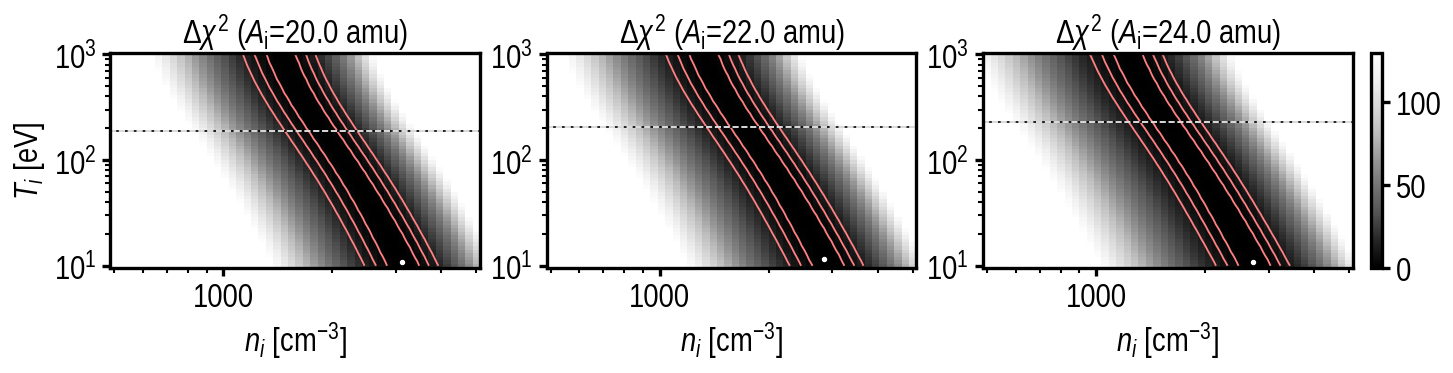

In [5]:
# 横軸 ni
fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=120, layout='constrained')
for i in range(3):
    z_value = chi2_3d[:, i, :].T-np.min(chi2_3d[:, i, :])
    print(z_value.shape)

    x_value = ni_3d[:, i, :].T
    y_value = Ti_3d[:, i, :].T

    # Scale height -> Ti
    Ti_thres = ((2.0*RJ)**2)*Ai_3d[0, i, 0]/((0.64*RJ)**2) - Zi*Te

    ax[i].set_title(
        r'$\Delta \chi^2$ ($A_{\rm i}$='+str(Ai_3d[0, i, 0])+' amu)')
    ax[i].set_xlabel(r'$n_i$ [cm$^{-3}$]')
    ax[0].set_ylabel(r'$T_i$ [eV]')
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xticks(np.array([1, 10, 100, 1000]))
    ax[i].set_xticklabels(np.array([1, 10, 100, 1000]))
    cn = ax[i].contour(x_value, y_value, z_value,
                       levels=[2.30, 6.17, 11.8],
                       # levels=[21.36, 30.48, 40.29],
                       colors=UC.pink,
                       linewidths=1.1,
                       zorder=2)
    p = ax[i].pcolormesh(x_value,
                         y_value,
                         z_value,
                         cmap='Greys_r',
                         vmin=0, vmax=np.std(z_value), zorder=0.5)

    # Location of the chi2 minimum
    x_best = x_value[np.where(z_value == np.min(z_value))]
    y_best = y_value[np.where(z_value == np.min(z_value))]
    ax[i].scatter(x_best, y_best,
                  s=5, color='w', zorder=2.5)

    # Threshold temperature
    ax[i].axhline(y=Ti_thres, linewidth=1.0, color='k')
    ax[i].axhline(y=Ti_thres, linewidth=1.0, linestyle='--', color='w')

    if target_moon == 'Europa':
        ax[i].scatter(1207/18, 87,
                      s=7, color=UC.lightblue,
                      marker='*', zorder=2.5)
        ax[i].scatter(1708/18, 195,
                      s=7, color=UC.lightblue,
                      marker='+', zorder=2.5)

    # Best fit parameter
    print('Best fit for A_i = '+str(Ai_3d[0, i, 0])+' amu')
    print('             n_i = '+str(x_best[0])+' cm-3')
    print('             T_i = '+str(y_best[0])+' eV')

fig.colorbar(p)
plt.show()

In [6]:
# Moon position when the Alfven waves launched (Time: t0-tau_A)
r_A0_arr = r_moon*np.ones(55)
S3wlon_A0_arr = np.linspace(-50, 370, r_A0_arr.size)
Ai_best = Ai_3d[min_idx][0]
ni_best = ni_3d[min_idx][0]
Hp_best = H_3d[min_idx][0]

# Ai_best = 20.0
# ni_best = 3433.2442250214995
# Ti_best = 70.38135554931559
# Hp_best = scaleheight(Ai_best, Zi, Ti_best, Te)

eqlead_best_MAW_N = np.zeros(r_A0_arr.size)
eqlead_best_MAW_S = np.zeros(r_A0_arr.size)
eqlead_best_TEB_N = np.zeros(r_A0_arr.size)
eqlead_best_TEB_S = np.zeros(r_A0_arr.size)
for i in range(r_A0_arr.size):
    r_A0 = r_A0_arr[i]
    S3wlon_A0 = S3wlon_A0_arr[i]
    S_A0 = Wave.Awave().tracefield(r_A0,
                                   np.radians(S3wlon_A0),
                                   1
                                   )
    tau, _, _, _ = Wave.Awave().trace3(r_A0,
                                       np.radians(S3wlon_A0),
                                       0,
                                       S_A0,
                                       Ai_best,
                                       ni_best,
                                       Hp_best,
                                       -1
                                       )

    eqlead_best_MAW_N[i] = tau*360/Psyn     # [deg]
    TEB_dt = TEB_transit(r_A0, S3wlon_A0)
    eqlead_best_TEB_N[i] = (tau+TEB_dt)*360/Psyn     # [deg]

    tau, _, _, _ = Wave.Awave().trace3(r_A0,
                                       np.radians(S3wlon_A0),
                                       0,
                                       S_A0,
                                       Ai_best,
                                       ni_best,
                                       Hp_best,
                                       1
                                       )

    eqlead_best_MAW_S[i] = tau*360/Psyn     # [deg]
    eqlead_best_TEB_S[i] = (tau+TEB_dt)*360/Psyn     # [deg]

Tracing field line 1 of 1 (100.00)%


Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (

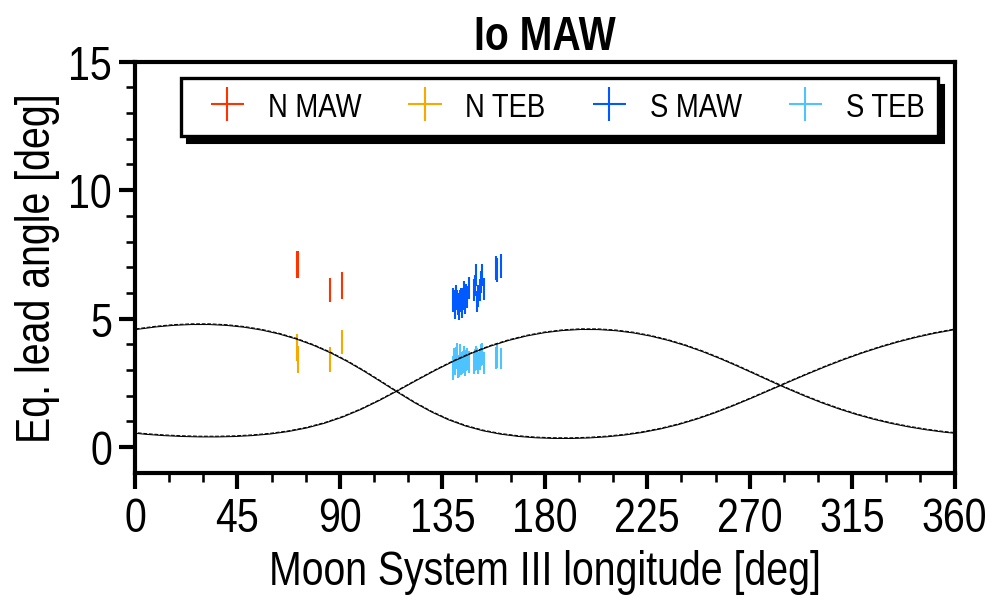

In [7]:
F = ShareXaxis()
F.fontsize = 23
F.fontname = 'Liberation Sans Narrow'

F.set_figparams(nrows=1, figsize=(7, 4), ticksize=1.5,
                dpi='M')
F.initialize()

ymax = 1
if target_moon == 'Io':
    ymax = 15
elif target_moon == 'Europa':
    ymax = 18
elif target_moon == 'Ganymede':
    ymax = 40

F.set_xaxis(label='Moon System III longitude [deg]',
            min=0, max=360,
            ticks=np.arange(0, 360+1, 45),
            ticklabels=np.arange(0, 360+1, 45),
            minor_num=3)
F.set_yaxis(ax_idx=0, label='Eq. lead angle [deg]',
            min=-1, max=ymax,
            ticks=np.arange(0, ymax+1, 5),
            ticklabels=np.arange(0, ymax+1, 5),
            minor_num=5)

north = np.where((hem_obs == -1))
F.ax.errorbar(moon_S3wlon_obs[north], eqlead_obs_MAW[north],
              xerr=np.array([np.abs(sigma_x[north]),
                             np.abs(sigma_x[north])]),
              yerr=np.array([np.abs(sigma_y_MAW[north]),
                             np.abs(sigma_y_MAW[north])]),
              linewidth=0., markersize=2,
              elinewidth=1.0, color=UC.red,
              label='N MAW',
              zorder=0.7)
F.ax.errorbar(moon_S3wlon_obs[north], eqlead_obs_TEB[north],
              xerr=np.array([np.abs(sigma_x[north]),
                             np.abs(sigma_x[north])]),
              yerr=np.array([np.abs(sigma_y_TEB[north]),
                             np.abs(sigma_y_TEB[north])]),
              linewidth=0., markersize=2,
              elinewidth=1.0, color=UC.orange,
              label='N TEB',
              zorder=0.7)

south = np.where((hem_obs == 1))
F.ax.errorbar(moon_S3wlon_obs[south], eqlead_obs_MAW[south],
              xerr=np.array([np.abs(sigma_x[south]),
                             np.abs(sigma_x[south])]),
              yerr=np.array([np.abs(sigma_y_MAW[south]),
                             np.abs(sigma_y_MAW[south])]),
              linewidth=0., markersize=2,
              elinewidth=1.0, color=UC.blue,
              label='S MAW',
              zorder=0.7)
F.ax.errorbar(moon_S3wlon_obs[south], eqlead_obs_TEB[south],
              xerr=np.array([np.abs(sigma_x[south]),
                             np.abs(sigma_x[south])]),
              yerr=np.array([np.abs(sigma_y_TEB[south]),
                             np.abs(sigma_y_TEB[south])]),
              linewidth=0., markersize=2,
              elinewidth=1.0, color=UC.lightblue,
              label='S TEB',
              zorder=0.7)

F.ax.plot(S3wlon_A0_arr+eqlead_best_MAW_N,
          eqlead_best_MAW_N, color='k', linewidth=0.5)
F.ax.plot(S3wlon_A0_arr+eqlead_best_MAW_S,
          eqlead_best_MAW_S, color='k', linewidth=0.5)
F.ax.plot(S3wlon_A0_arr+eqlead_best_TEB_N,
          eqlead_best_TEB_N, color='k', linestyle='--', linewidth=0.5)
F.ax.plot(S3wlon_A0_arr+eqlead_best_TEB_S,
          eqlead_best_TEB_S, color='k', linestyle='--', linewidth=0.5)

fig_title = target_moon
for i in range(len(target_fp)):
    if i == 0:
        fig_title += ' '+target_fp[i]
    if i > 0:
        fig_title += '&'+target_fp[i]
F.ax.set_title(fig_title, fontsize=F.fontsize, weight='bold')

legend = F.legend(ax_idx=0, loc='upper right', ncol=4, markerscale=4,
                  fontsize_scale=0.7, textcolor=False, handletextpad=0.2)
legend_shadow(fig=F.fig, ax=F.ax, legend=legend)